In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')

df

Now we want to predict X values (can change for Y, Z):

In [ ]:
#Create a new dataframe with only the x column
data = df.filter(['x']) # CHANGE FOR Y,Z

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 ))

training_data_len

In [ ]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# Set roll-back window
window = 60 # default was set to 60 before

In [ ]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

In [ ]:
#Create the testing data set
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - window: , :]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

# Model 1: Uni-Variate

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1))) # input_shape = (60,1)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(x_train, y_train, batch_size=16, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

In [ ]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

### Plot:

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(train['x'])
plt.plot(valid[['x', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### Error plot:

In [ ]:
valid['Error']=abs(valid.Predictions-valid.x)/6738 # the normalization ct is taken as ISS semi-major axis
valid.Error.plot()
# add labels and units!!!

# Model 2: Multi-Variate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [2]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 2])
    return np.array(dataX), np.array(dataY)

In [3]:
# load the dataset
dataset = df.values

In [4]:
# split into train and test sets
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size

train=dataset[0 : train_size]
test=dataset[train_size - 60 : ]

In [5]:
train.shape

(800, 6)

In [6]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [length of train/test data, window size (def=60), features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
testX = np.reshape(testX, (testX.shape[0],look_back, 6))

In [7]:
trainX.shape

(740, 60, 6)

In [8]:
testX.shape

(200, 60, 6)

In [9]:
testY.shape

(200,)

Epoch 1/10
3/3 [==============================] - 0s 154ms/step - loss: 0.1913
Epoch 2/10
3/3 [==============================] - 0s 152ms/step - loss: 0.0626
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 0.0573
Epoch 4/10
3/3 [==============================] - 0s 133ms/step - loss: 0.0435
Epoch 5/10
3/3 [==============================] - 0s 137ms/step - loss: 0.0425
Epoch 6/10
3/3 [==============================] - 0s 131ms/step - loss: 0.0383
Epoch 7/10
3/3 [==============================] - 0s 131ms/step - loss: 0.0308
Epoch 8/10
3/3 [==============================] - 0s 144ms/step - loss: 0.0266
Epoch 9/10
3/3 [==============================] - 0s 137ms/step - loss: 0.0239 0s - loss: 0.02
Epoch 10/10
3/3 [==============================] - 0s 147ms/step - loss: 0.0185


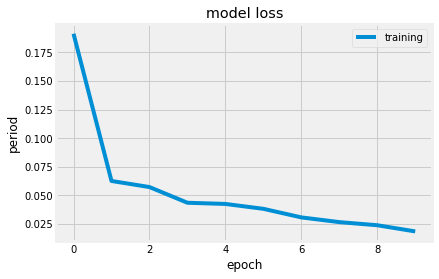

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(6))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(trainX, trainY, batch_size=256, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

In [11]:
predictions = model.predict(testX)
predictions.shape

(200, 6)

In [12]:
predictions

array([[0.6927103 , 0.67929655, 0.6199513 , 0.74119085, 0.6782881 ,
        0.6616647 ],
       [0.6507063 , 0.61661196, 0.5924159 , 0.68547803, 0.608634  ,
        0.6053868 ],
       [0.5895378 , 0.5343648 , 0.55454856, 0.60479945, 0.5241342 ,
        0.5339387 ],
       ...,
       [0.54611987, 0.564657  , 0.5434963 , 0.5559024 , 0.6243147 ,
        0.57862365],
       [0.6207135 , 0.6472492 , 0.5872735 , 0.6506287 , 0.69661236,
        0.6503057 ],
       [0.680335  , 0.7067977 , 0.6216695 , 0.7274179 , 0.744677  ,
        0.70065725]], dtype=float32)

In [13]:
pred = scaler.inverse_transform(predictions)
pred

array([[1.5850594e+04, 1.4641871e+04, 5.5734551e+03, 1.4713777e+00,
        1.1766833e+00, 5.4795092e-01],
       [1.2254343e+04, 9.1331982e+03, 4.3374272e+03, 1.1222060e+00,
        7.3182034e-01, 3.6714116e-01],
       [7.0172856e+03, 1.9053846e+03, 2.6376101e+03, 6.1656493e-01,
        1.9214176e-01, 1.3759272e-01],
       ...,
       [3.2999773e+03, 4.5674351e+03, 2.1414888e+03, 3.1011003e-01,
        8.3196914e-01, 2.8115654e-01],
       [9.6864502e+03, 1.1825577e+04, 4.1065894e+03, 9.0379280e-01,
        1.2937157e+00, 5.1145661e-01],
       [1.4791059e+04, 1.7058652e+04, 5.6505811e+03, 1.3850577e+00,
        1.6006924e+00, 6.7322612e-01]], dtype=float32)

In [17]:
pred[0]

array([1.5850594e+04, 1.4641871e+04, 5.5734551e+03, 1.4713777e+00,
       1.1766833e+00, 5.4795092e-01], dtype=float32)

In [ ]:
# Get the models predicted price values 
predictions = model.predict(testX)
#predictions = scaler.inverse_transform(predictions)

# Get something which has as many features as dataset
predict_ext = np.zeros((len(predictions), 6))
# Put the predictions there
predict_ext[:,2] = predictions[:,0]
# Inverse transform it and select the 3rd column.
predictions = scaler.inverse_transform(predict_ext)[:,2]

testY_extended = np.zeros((len(testY),6))
testY_extended[:,2]=testY
testY=scaler.inverse_transform(testY_extended)[:,2]

In [ ]:
# RMSE
rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
rmse

In [ ]:
# Plot the data
train = df[:train_size]
test = df[train_size:]
test

In [ ]:
testY_rescaled=scaler.inverse_transform(testY)

In [ ]:
dataa = {'testY': scaler.inverse_transform(testY), 'predictions': scaler.inverse_transform(predictions.reshape(testY.shape))}
dff = pd.DataFrame.from_dict(dataa)
dff

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Testing data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(dff.testY)
plt.plot(dff.predictions)
plt.legend(['TestY', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
predictions